In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib
from sklearn.model_selection import cross_validate
import zipfile

from src.model import tscv, ClippedOutputRegressor
from src.feature_engineering import get_feature_cols, df_to_X_y, drop_non_features, add_lagged_features


%run constants.py

baseline_reg = joblib.load(os.path.join(MODELS_DIR, 'xgb-baseline.model'))

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


In [18]:
sales_train = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'sales-train.parquet'))
train_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set.parquet'))

Let's try getting the release date of an item, or more precisely, the number months since the release.

We will check the global release date and the release date for a shop.

In [22]:
groups = [['item_id'],
          ['item_id', 'shop_id'],
          ['shop_id']]

In [23]:
df = sales_train[['item_id', 'shop_id', 'date_block_num']].drop_duplicates()
for group in groups:
    group_id = '_'.join(group)
    release_date_col =  '%s_release_date' % group_id
    feature_col = '%s_months_since_launch' % group_id
    release_dates = sales_train.groupby(group)['date_block_num'].min().reset_index().rename(columns={'date_block_num': release_date_col})
    df = df.merge(release_dates, on=group, how='left').fillna(-1)
    df[feature_col] = df['date_block_num'] - df[release_date_col]
    df[df[feature_col] <= 0] = -999
    
df.describe()

,item_id,shop_id,date_block_num,item_id_release_date,item_id_months_since_launch,item_id_shop_id_release_date,item_id_shop_id_months_since_launch,shop_id_release_date,shop_id_months_since_launch
count,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06
mean,7.397643e+03,-2.387890e+02,-2.514327e+02,-2.587730e+02,-2.559702e+02,-2.577759e+02,-2.569673e+02,-2.628989e+02,-2.518443e+02
std,7.350269e+03,4.550171e+02,4.473029e+02,4.428994e+02,4.445698e+02,4.434966e+02,4.439682e+02,4.403811e+02,4.470559e+02
min,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02
25%,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02
50%,6.002000e+03,2.500000e+01,1.100000e+01,0.000000e+00,5.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,1.000000e+01
75%,1.395900e+04,4.300000e+01,2.100000e+01,8.000000e+00,1.200000e+01,9.000000e+00,1.000000e+01,0.000000e+00,2.000000e+01
max,2.216800e+04,5.900000e+01,3.300000e+01,3.200000e+01,3.300000e+01,3.200000e+01,3.300000e+01,2.100000e+01,3.300000e+01


<AxesSubplot:xlabel='item_id_release_date'>

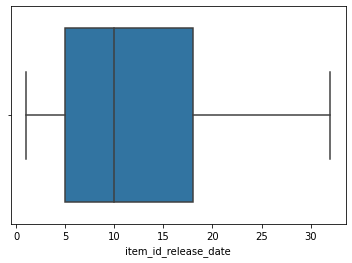

In [24]:
sns.boxplot(df[df['item_id_release_date'] > 0]['item_id_release_date'])

<AxesSubplot:xlabel='item_id_shop_id_release_date'>

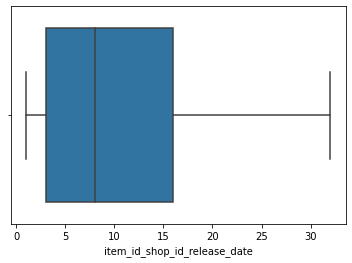

In [25]:
sns.boxplot(df[df['item_id_shop_id_release_date'] > 0]['item_id_shop_id_release_date'])

<AxesSubplot:xlabel='shop_id_release_date'>

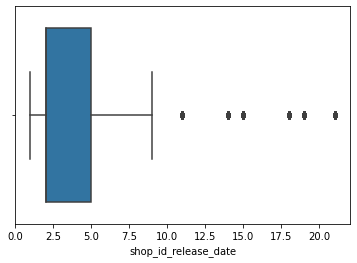

In [26]:
sns.boxplot(df[df['shop_id_release_date'] > 0]['shop_id_release_date'])